<a href="https://colab.research.google.com/github/punisher21maximum/ArtificialIntelligence/blob/master/ParkingOptimistaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object detection


## Setup


In [0]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.2.0-rc3
The following GPU devices are available: /device:GPU:0


In [0]:
### ** Parking : 3 floors for 4 classes **
#### floor 0 : 10 parking : class A - 7, class B - 3
#### floor 1 : 10 parking : class B - 8, class C - 2
#### floor 2 : 15 parking : class C - 5, class D -10

In [0]:
#### empty parking array

In [0]:
def get_parking_all():
  parking_all = []
  temp = []

  break_floor_0, break_floor_1, break_floor_2 = 7, 8, 5
  num_of_parking_0, num_of_parking_1, num_of_parking_2 = 10, 10, 15

  for i in range(num_of_parking_0):
      if i < break_floor_0 : temp.append(['A', 0])
      else : temp.append(['B', 0])
  parking_all.append(temp)
  temp = []

  for i in range(num_of_parking_1):
      if i < break_floor_1 : temp.append(['B', 0])
      else : temp.append(['C', 0])   
  parking_all.append(temp)
  temp = []

  for i in range(num_of_parking_2):
      if i < break_floor_2 : temp.append(['C', 0])
      else : temp.append(['D', 0]) 
  parking_all.append(temp)        
  for i in parking_all:
      print(i)
      
  # print(floor_map[0][0][0])
  return parking_all

In [0]:
#### fill empty parking ranomly

In [0]:
import random
def randomly_fill_parking_all(parking_all):
  for floor in range(len(parking_all)):
      for parking in range(len(parking_all[floor])):
          parking_all[floor][parking][1] = 'P' if random.choice([0,1]) == 1 else 'E'
  for i in parking_all:
      print(i)
  return parking_all

In [0]:
parking_all = get_parking_all()

In [0]:
parking_all = randomly_fill_parking_all(parking_all)

In [0]:
#### [['A', 'E'], ['A', 'P'], ['A', 'E'], ['A', 'E'], ['A', 'E'], ['A', 'E'], ['A', 'P'], ['B', 'P'], ['B', 'E'], ['B', 'P']]
#### [['B', 'P'], ['B', 'P'], ['B', 'E'], ['B', 'P'], ['B', 'P'], ['B', 'P'], ['B', 'E'], ['B', 'E'], ['C', 'P'], ['C', 'P']]
#### [['C', 'E'], ['C', 'E'], ['C', 'E'], ['C', 'E'], ['C', 'P'], ['D', 'E'], ['D', 'P'], ['D', 'P'], ['D', 'E'], ['D', 'P'], ['D', 'P'], ['D', 'P'], ['D', 'P'], ['D', 'E'], ['D', 'P']]

#### 'P' - vehicle parked there ; 'E' - vacant parking

In [0]:
## Get a vehicle of some class

In [0]:
all_classes_of_car = ['A', 'B', 'C', 'D']

In [0]:
# get class - randomly
class_of_car = random.choice(all_classes_of_car)
class_of_car

'A'

In [0]:
# get class - from width
def get_class_of_car_from_width(width):
  if width<450: class_of_car = 'A'
  elif width<550: class_of_car = 'B'
  elif width<650: class_of_car = 'C'
  else : class_of_car = 'D'
  return class_of_car

In [0]:
for a_class in all_classes_of_car:
    if a_class >= class_of_car:
        print(class_of_car, a_class)

A A
A B
A C
A D


In [0]:
def parking_slot(class_of_car, parking_all):

  flag = 0
  for floor in range(len(parking_all)):
      for parking in range(len(parking_all[floor])):
          if parking_all[floor][parking][1] == 'E':
              if parking_all[floor][parking][0] >= class_of_car:
                  print('----------------parking----------------------')
                  print('parking found : floor', floor, 'parking slot', parking+1, 'class', parking_all[floor][parking][0])
                  flag = 1 ; break
      if flag == 1 : break

In [0]:
parking_slot(class_of_car, parking_all)

----------------parking----------------------
parking found : floor 0 parking slot 1 class A


## Example use

### Helper functions for downloading images and for visualization.

Visualization code adapted from [TF object detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py) for the simplest required functionality.

In [0]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               object_name, 
                               object_per,
                               thickness=4,
                               display_str_list=()
                               ):
  if object_name in ["Wheel" ,"Window" ,"Tire" ,"Door"] and object_per > 50:
    return
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  # print(xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
  
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  '''
  here

  '''
  if object_name=="Car":
    print("class : ", object_name, object_per, "width : ", right-left, "height : ", bottom-top)
    #parking code

    parking_all = get_parking_all()
    parking_all = randomly_fill_parking_all(parking_all)
    class_of_car = get_class_of_car_from_width(right-left) 
    parking_slot(class_of_car, parking_all)


  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
            (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
       
      ymin, xmin, ymax, xmax = tuple(boxes[i])

      object_name, object_per = class_names[i].decode("ascii"), int(100 * scores[i]) # car 93%


      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          object_name, 
          object_per,
          display_str_list=[display_str]
          )
      np.copyto(image, np.array(image_pil))
  return image

## Apply module

Load a public image from Open Images v4, save locally, and display.

Image downloaded to /tmp/tmpgviudfzf.jpg.


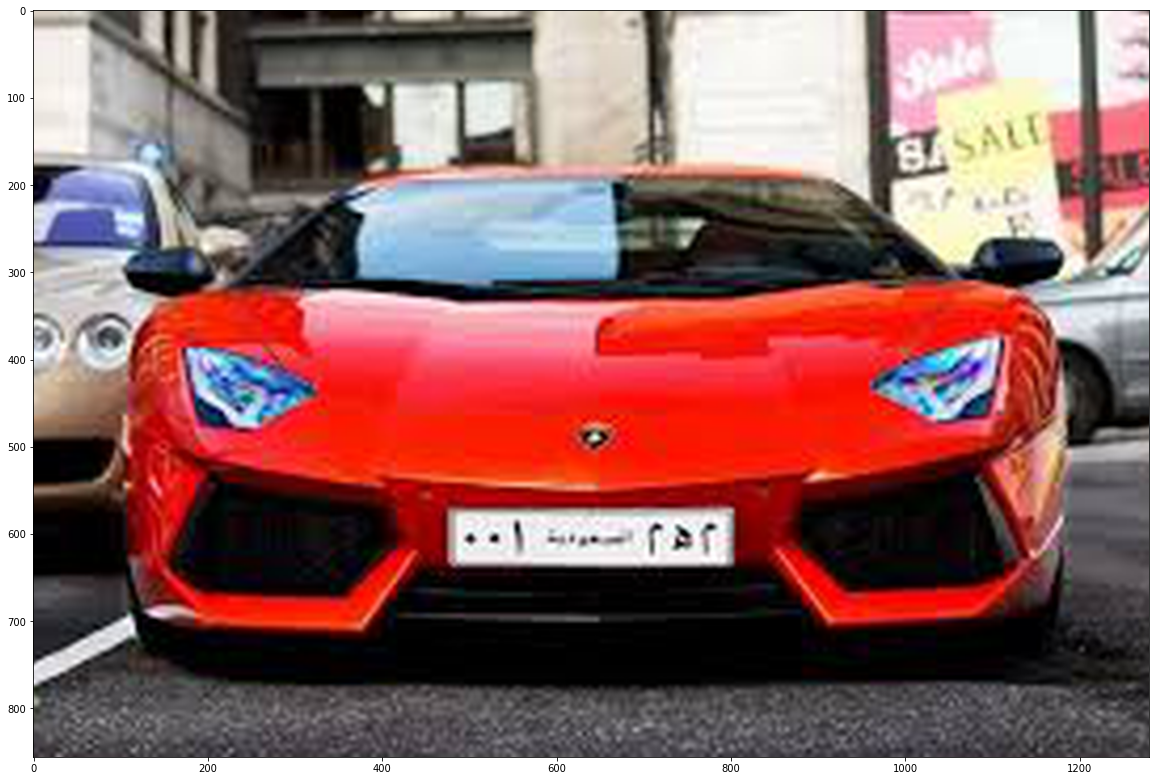

In [0]:
image_url =   "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSOgaulopZlTkcwvf5TQ8gSqOiWiSztyeiSwIW1x7URptmOYww8&usqp=CAU"#@param
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

Pick an object detection module and apply on the downloaded image. Modules:
* **FasterRCNN+InceptionResNet V2**: high accuracy,
* **ssd+mobilenet V2**: small and fast.

In [0]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [0]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

In [0]:
run_detector(detector, downloaded_image_path)

### More images
Perform inference on some additional images with time tracking.


In [0]:
#for 50 images

image_urls = [
              "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUSExMVFhUXFRgVFxYXFxUYGBcYFhcXFhUVFRUZISggGBolGxYVITEhJSkrLy4uFx8zODMtNyktLisBCgoKDg0OGhAQGyslHx8tLS0tLS0tKy0tLS0tLS0tLi0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIALEBHAMBEQACEQEDEQH/xAAcAAEAAQUBAQAAAAAAAAAAAAAABAIDBQYHAQj/xABKEAACAQIBBwgFCAgFAwUAAAABAgADEQQFBhIhMUFRBxMiUmFxgZFCkqHB0RQjMlOCorHSFkNUYnKy4fAzNJPi8URzwggVJWOD/8QAGgEBAAMBAQEAAAAAAAAAAAAAAAECAwQFBv/EADURAAIBAgMHAgUDBAIDAAAAAAABAgMRBBJRBRMUITFBUhWRIjJCYaFxgbEjU9HhwfAzNPH/2gAMAwEAAhEDEQA/AO4wBAEAQBAEAQBAEAQCzjMUtNC7mwH92kSkoq7L04SnLLE1GpygUxYsqIpF1LvZiNxCAEzn4haHox2XUf8AogYnlKojZVTwo1n9p0RKuuzeOyJ90/dIg1eUxd1Wp9nDqP5nkb96mi2Q9PyQq/KXwfE+FPDj3yrqy1NVsqK6pe7Ij8pT9fE+VAfhI3k9S3psF9K/JZblJfrYn1qQjPPUen0/FfkttyjvxxX+pTkZ5akcDDxQHKS/HFf6lP4RnlqOCp+KLq8prD0sV50T+MnPLUo8FT8V+S7T5TzvfFephz75O8nqVeBp+K/JMp8qQ31a32qFI/yvLb2Wpk8BHx/JKpcqab6w+1h6g/lYyd9LUr6fHR+6M1gOUrCOtmrUlfdpc6invLL0fbNI1l3Oaps+a+VMzOR86qVaq1A2WoLWIYNTcMumObcbejc2sNhtexteNRN2OeeGnCGd9DYJoc4gCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAcv5VMvk6eHQ2CrosR13HuU385yVHnqKCPbwdJUMPLES6vocrx2U2d2comkxuf8Q9wHS2DYBN+GgYLbOIisqt7ENsov1afqt72jh4FXtnFar2KUxlVtgQfYX3ydxTXYo9rYt/Ues9brqO5E/LG6p6FHtLFP62Wzzv1n3V+EbuGhX1DE+bKW5z6w+QhwguxMMZiZyyqoy6MJVP632Sl6eh1Xxj+titgay62qGIunJ2SFdYyjHNObLXM1PrD5CabuGhycdiPNjmanX+6JG7hoSsfiPINTqj0gfARuoaFltHEeX4LXPP2eUjcQLradfVexcWs37vkfjI4eJZbVraI2rk9xejilpk6IqjQBHo1FOnScdoYW+2ZSdJQ5ovHGSrvLJL/Op9C5OxPOU1cix2MODA2YeYM2i7q55tSGWTRJliggCAIAgCAIAgCAIAgCAIAgCAIAgCAIBEytj1oUalZvo00LHtsNQHaTYeMiTsrmtGk6tSMF1bsfPmUq7VDpObsxao38Tk/wC/znNhleTkz3NsyVOEKMeiMRVoTtPnWj05OsASNZFx2cJBBQcKbgjhIFyh0P8AYggtHviwPadNjsUkcQCfwiwKwpXrL4kSuRPsaxr1I9JMqFFjr0XPaQx/GEkuhWdSc/mbf6lBPhJKAQSisoT/AMQWPPk4sbjft+EAtVcJom3keIlrgkYQMpDL9JSGX+JSCvtAlJrMrGlKeSakfQOa+VA7Lb6NekKyfxAKHHirUzbsaY0pdjqxVPlmXb/qNmm5wiAIAgCAIAgCAIAgCAIAgCAIAgCAIAgHP+V7KmhQp4e9ucbTf+BCLAdpcrYdhmFd8lHU9vYlJbyVaXSP8s5bS1gsRtY2HAL0B/Lf7U2pRUY8jgx9d1q8pP8AQroYXScLxM0OJk/F4bpapBUy2VFp0aKnm0ZyoVbqOGsnsHvkIk06sWvfUO5VA8rWlrEGyZq48VCaVRU07XVgqrpAbQQBa429ovw11aLJmwZRDpSdqa3cKSq2Jud2obe6QSaHjTjarKz0CSp1fMbexrjpLr2HVLcipsubNTGMzDEIVQJ0boE13AAAFtVr7pDsSjIZdxS0KRqMoY/RVT6THYO7ee6QDn2Jx1WobsVHYqIoHdYfjeSDM5s4tTUFKrTptpalbm0uG3A2GsHzkEl3OnCBatgABYGwAHo22DugghZSwd1DDdaCEWcJhtYkljcMh5TahRDG5+SYkHX9VUGlqtu5upVW3GmJzTWWWZHq4b+vB031a5fqjsSMCAQbgi4PEHZOg8pqxVAEAQBAEAQBAEAQBAEAQBAEAQBAEAQDgOf2WTiMbVqA3SjdKY3HmrgnxfSA7O+cknmqWPqsHTVHC53o2RVoaKheqAO+wtedy5Hy0pOTbfclZKUc5fgpI74KS6E8Jc/33SGQSs6aXzgTqIB4kXPst5QiWYzDZtV6qc4iXXXa5A0rdUGTcixjcCDSr02IsUqC/ZrswPhcQDqpwfZKFx8k7IA+R9kA0HlGb52lS6qFz3sbD2L7ZZEMxWSc2cRXTnKaDRuQCxC3I2heMMkiCk1N9YKujbDtDKdnmJUG1Z10gaiMB9Kmjjxv8YI7kVKF6TX3L+Gq0kjuWsFg9YklrmTSgDVqUfr8K4+3QOmniUqVPKZVFz/U7sHN25dmmbnyT5b+U4BFY/OUGNB/sW0D4qV8QZFN/CZ4xWqt68zcpocogCAIAgCAIAgCAIAgCAIAgCAIAgGGzxyt8lwVeuCAyoQl/rH6FP77LIk7K5pShnmkfP2EpC1MdIqaiC+02T5wk+qPOctNKMryPp8RJ1MLu6a5vkbBUw9xcawdhGsec7lZq6Pk5RlB5ZKzIrIRBBdpY1xwPeIIsSK2VndizgMx2k790FrF5M5MQgARiANQF7gDgARFiLMw+Ox5qMzsvSY3JBAuTvsBYQLG1UuUmygNhQTbWRVsD2gFDbzkWJuenlNX9kP+qPySLApPKgv7If8AVH5IsSahnBnB8qrmsaYTohQoa+pb2uSNZ18JaxFi/hc8cTTprSptooosABT79ujc6yZFgQ62VmqOXcBmbWWJ1nVbcOyQLExstVKmiGsdFQi33KNg1SBYm4euW1E6uA1D+ssSTji0QayJJDRj1yx8/SqqCVpVFLkDUq1L0jpHYLhzt2zGq1yO7BRab0aMvyVZSFHKFWhey1xUA7Xpu7pbvQ1fJZnS5Ox0bQimlLQ7NNzyhAEAQBAEAQBAEAQBAEAQBAEAQBAObctuPtQw+HG2pVLleK0lsB3abofszGs7RPT2VSz1r2vY0/NLB6VUbwtJieF2KqD915zt3R7+LtTyRXVGexGb+stRY02O0bVbvU6vfwtIjOUH8LOSo6dZWqxv9+5BrYaqv+Lhy371Ig+Ogx1esZ0xxXkjzqmy4t3pT/ZmKxOhuFQdhpt/43mnEU9TlezMSvpv+6I2mvFvFHH4iTvoambwWIX0M8NZOsPaJO8hqV4at4P2I9V066+cneR1I4er4v2IlSqnWHnGeOo3FTxfsWGdeIjPHUbip4v2LD1BxEZ46jc1PF+xbNURnjqNxU8X7HnOHgfIyM8dRuKvi/Yuo56req3wlc8dSeGq+L9iVQFQ7KVQ/wD5v8JG8hqXWDrv6WTCmItqUIOtUZEA9Y39kq68Uaw2dXl2KBTpjXVqNWbqU7on2qzDSI/hUd8xliG+h6dDY3eb/wC/oeY3HM6aFlWmtytJBooDtvb0m/eYk9sxzNs9iOGp0oNRRcp43mMRRxKnVTqJUPEBWBb1k0hNYytJGG0aKnQbXRr+D6SU3FxsnYfGnsAQBAEAQBAEAQBAEAQBAEAQBAEA0XOZ1bGsWpLUFKkqDSAaxYl2sCN4NPyExqPmdlGUox+F2uYrCOrYrEuECWWhS0QAACtM1TqH/emVV9DuoZpK7dzI84Jlc6MrPDWEi4yMtvXG+RcuosiVaqdVfISDWKlqQK9ROqvkJVtG0VLUgV6i8BKm0VIxuJr8IOiKMjh8KjPVpqXHNJp6TIjc4N2iWYizbVIA1cds6Ywj00PMq1qkYxnJ/M7cn0/Br2UKylUdNNdLSup1CwtZ16RsDcjbtU2tKSS6o9DDud5QnZ27/wDBBas3WPmZQ3Zbau3WbzMFWWjWbrN5mWsQygueJ84KlIgnMysPFibla1JFibmYwNTnMKimgp0UKF9EXYi6kEzZpXvc+YrTnGbSfKx3TM/EmpgsOx280qn+JBoN7VM7F0PIn1MxJKiAIAgCAIAgCAIAgCAIAgCAIAgHPMRj6QxOKaogJ5/RU9LWEREI1HiplcqfU2cpKy+xruFyiDVxTj08XVPgmjSHspzirO0rHv4KlelcknKQ4zG517ktNlLti5Kokd8pdsi5oqJGqZR7ZBdUiJVyhBqqRCrY28mxooESpXvLWNErCnj6iiy1HUcAxA8pZTkujMKmGo1HecUyM7km5JJ4k3PmZDdzRJRVoqyLbNIIbLTGWKsogqIAghs8vBFz2Cbm2ZksjYd0ex0cQ4sSRqZVYaxs1kzqpxTV2j5fHtxq2T1/k6pybVQcHojVoVqq24XcuB5PN0edPqbVJKCAIAgCAIAgCAIAgCAIAgCAIAgHFcn5xhcfXSqV0Di6pXTAKg86wsTuGq9/+Zzwq2k0z262BdShCcF8SXNa/wCzVqGP+mdgarVb1qrn3zlqc5HuYGlagv3/AJLvy4yljryIoONPGLE5EW2xJixOVFBrmSTYoNSCSktAKC0EBbm/YCx7htMvGDl0OXEYqnRtn7lDNKGrZbZpYgogqIAgCCtim4gmxVb4f0kkKxm818rLQpYoMQCalMqLXY3pkEL7Ne7ynRCajHmeBjcLOpiHl6X66ckdM5FcY1XDYgsdfyonuBpUjb8ZpSbauzgx0FCaUdDoc1OIQBAEAQBAEAQBAEAQBAEAQBAEA+ZMt6sTWbc1aob8L1G9l55r5tn2UFlhHSy/bkW8l4g09BxrIuRs2nSsdYI331jdLN2lc3p095hlG9r/AObkvE48MjItMJpDRJBGsXvbUoNrgb92+HNNckZxwdRSTlUbt2f/ANLOMr6dR3VdEM1wotqG4dEAbOAEpJ3dzrowdOmoyd2u5RzTdU+RkGmeOpQ1xtgZ46lGnBGdHmlAzo9BG86vb3Dt+B7jJSUrFD1FO4+JH5ZKujGahP5udilqg4G/eD7hBOcpgtcCCLlxaV94kXJ5F9cETs1+UXF1qUPhGG4xclWM7Ry2baPyenrUJr09miFAOjtW+k2jxbsF9FV7WPOns5c5Ob1JOXnrcyyOcPrqWYJzmmCDcnpGxX5pBpWJtaxsTJm3bnYpgqdLe3jm5Lv0NOrizMN50SB3rb3SvWKNa3/lkl1djrnIQfmcUL3HPKfEprPdqHlOmh0Z4e04pSjbQ6jNzzBAEAQBAEAQBAEAQBAEAQBAEAtYqsERnOxVLHwF5DdkWhHNJLU5QuZPynAJWQhcQb1Vv9Fw50mpvwBvqO49l5yQp3jc+hrY50sRkXRcjnVXCPQtSqoyMABZha9uqdjeBMxl1PYwtSCpRin0QVCZU6G2+hnsk5s86LtW0Rv4DvOyE79Dhr11T6k+rmlggP8ANFj+6hceagibbmVjzntWCdrIwuPyThk+jWY99Nx7pG5qaGsdp4d9TD1qdIemPK0ndT0NePwfkWC9L6xY3U9CHjsJ5oobE0wCBUFja4vwvb8TG6noV47C+aKlq4Xe7ez4yN1PQcXgvMpbE0FN0Y34sRqk7qeg43BrpIpStSO2oI3U9CONw3mibRpYc7a4HcpPukbupoVeOwy+oyGFybhGOvEP4U2/LCpVNCj2jQXRmcwuauTmGvFV/Ci35JoqEjCW1orokXMRmbhh/g4wk7lZQCfs9Eyk6bib0Noxm7WXuYurknEUvosKoG4jX5H3GYcj041Yy+xHbKdML0l0G4HUPD4RlfYvmUecmWEyFXql65VqdEqvSYFWfR0ujTB12N9beU2byxVzglLeV3kfJpXffkb9yJVwtXFUdl1puB3aSm3mJrh3zaOHbNOyi1+h1qdR4IgCAIAgCAIAgCAIAgCAIAgCAa5yhY3msBWN7F15sfb1H7ulMqztBnfs2nnxMftz9iTktAMNTC2K82oBGsWAGwyYL4EVrt76TepicoYRWuHVWU7mAI8jMJROynN25M17FZo4NtfNaB/+tmT2A29ko0jqjiqq7kGrmigtoYmuttg+bYDtsy7e2IyydCtb+v8AOvyyLiM3627Gsf46NM/gRL7+RhwFJ6+/+jEYvNqu3/U0j30mH4NHEvQn0uD6SZisRmfWP66l6rj3mTxP2IeyV2l+CBVzMrfWUvv/AAjiloPR35fgjNmfXHp0vNvhHErQn0Wfl+C2c1K3XpebfCOJWg9EqeSKDmxW61Pzb4SeJWg9DqeSPVzbqj06fm3wjiVoT6FU8kXkyFVHp0/vSOKWhb0KfmvYv0sn1l/WU/VY++OJ+xdbCfef4J9FcQNlZR3Ux7zKvEvQ0Wwod5smUsJWqamxNS3ALSA/llXiZE+j0Y87s2zI2baMoFStiHA3GqV8ylifOUi8zuytX+mrRNqydm9haJ0qdCmG65Gk/rtc+2bpI4JTlLqzH53NemRMap24JfEafyaYg08qINzo6N7CPaJNF2kjr2rTzYdvQ7rO8+SEAQBAEAQBAEAQBAEAQBAEAQDnHLPjLUaNLrPpHw2fgZy4l9Ee9sKnepKeiOaZOypWo/4VWonYrsB6t7TmUmuh9JUo0qnzxT/Yy1LOzH2uKjOOJpqw8wstvJHK8BhtLfuVfpnix9JKZ76bD8DGcjgKHZv3Bz2q76VPzce8yLjgYdpMpbPFt9FfBz+WRcng0u/4KGzqv+q+/wD7ZA3Fu5afOQfVn1h8ItclUiy+X16h8x8Iyl8tiO+XF6pHiIyk54x6kdssLwPmJOVjf09Sg5TH9kRlZKr09Tz5d2e2LF1UTAxnZFic578qPCQM5UuKPCBe5Io5UddgXxvIsQ4XMjQzqxS/QCeoT75ZOxzzwlOXUvHO3KL6lY/Yoj4GTnZlwOHjza/JhspZSxTkitVq33q1181AEX1N4UqcV8CRayFijSxNKpwceR6J9hi5WtDPTlH7H0tQqaSq3EA+YvPRTurnw8lZtFySQIAgCAIAgCAIAgCAIAgCAIBx3llxF8TTTq07+2//AJTixD+I+n2HG1Jy1ZpWTcPzjhZzs9qpPLG5jc9TWTF80r1FUKgpqhOzRW4A3Ekkk8TO2hFOPQ+S2jVqKqmpPmjDnGV10tGvVOidzs20nWRu2Wmu7hocaxdddJszWQMqsWdK7NUsdXTINthGrgZzV6ajZo9vZeJnWzQnLmuhtOHXBP8ASWoD/H8ROe56ko110kYvLODpq16RYr2n+kJmsFJr4upimXtPnJFvuWiO0+ckhr7njICCDYg9YXF90lOxnKEZJxfP9SF8ibhh/JppnX3ODhZ6QLlDCWN2FHVs0VN7952SJT0ua0cNlleSj+xIZhf6R9kodlufU9BHWPnIJS+5dprfefOGWUFqZTCjDhemju3/AHGUeyVuTKjNv4ZWRbr1qfoU9H7dQ/iZJbJlXxSNbxmPcv0HfR0tHU19wuLbhe+vXa2vbO6FKKXNHyGJ2hWlUlkm0r8iJVxtXRJ5x9RtcMdmvaN17eFu2XyR0OSVerLrJ+50fDZMdsFTFU6VRC1idZ0ClNtC/AOandrnFWtm5H0ezZyjBZn1X+f+LGuVlt3iZo9do+jc1MRzmDoPxpj2avdO+k/gR8Ti45a8l9zLTQ5hAEAQBAEAQBAEAQBAEAQBAOGcrNT/AORYcKae0f0nDX+c+r2P/wCv+7MHkTEBHuZgz0qsc0bEfPRRiNGoBcqLEcQLm2rsJ9WdGHnzszwtqYR7pTXb+DXKpDrUYdIafpWo2Nm9K9na1r9moTuPnj0pou7KLlbDWBTAvu0mPS1C4vuErOKkrM2w9eVCopx7EqllQXswINgb2JFjrBBtsnJLDyXQ+jobapS5TVj2vWepvITdbf2kiZWynTKq63OL5fY6XmrjDQybhAlNalWtUrqgYlV+barUYsVVmJ0UICqpJM7KXyHzuObjWaJKZ5o1uaoaVsM+IqsRWCqUFUc2pNHr0WBZ9AcLnVNLHHnZXSzqL0nrCgoWi9NK9NmAcGol2CaVgWVrgD0hYiZ1JZVc7MHSWIk6d3d9P9l3EZxaGExON5lDTpstOkmkumzmoKZNW1xTGky6ttgeIinLPz7E4ygsPaF3m76faxDrZ1VkJw74fDjFDErhtdQjDjTpc6HaoV0hq1WtrPlNLHFnYTO2pUWmtHCUTXPyo1Vd/m1GDIFTQdVu2lfV7ZGUZ2WMbn50TVp4WjzVPD0MRVFWoEqEV9iUF0bOV4nbGUZ2YDlRoL8uBUaN8PSIsLHWXOsDfOWtykfQbNhmo3vzuzVflmjqfbuta58N0zVNy6HdLaEKKtVfP7EZ8pliugNRNtdx2XHnOinQs7s8jGbXdWLhTVk+/cgrTso2aqhHS6NrAXv1rar8ejbYZ0HimRyZk8VarK9wqPzlTT1agSCv7ztqF+6RJ5Vc0o0nVmoR7m6tli67t/mSWPtJnlybbPtI4dR5I1/FtckyUdFuR3jk1qaWTcOf3SPJiJ30fkPjtpK2JkbPNTgEAQBAEAQBAEAQBAEAQBAEA4fyy0CuUFfc9BPNWcH3Tjr/ADH02x5f0WtGangqTOQF2mc7PaukrszFTIVYC5AkXsZb+nLkYbGZKXYy776tYvr16J1bzOiGIa68zza2xaNXnTeV/gxuJwDnSIKuW9F/ojXchVOzXr2idEa8WeRW2TiaXa6+xDroQSGDL0bdPpJfo3soGq9iTbuE1TTPOlFxdpKxa0CLEEgaH0r9HUL/AEBrBtu3C0NIRm4807HQ8189MDSydSweLw1TEWNRz0KT0yWqVHWwdw17HhCVuhLm5c5czJ1OUbJTimP/AG+owRWp0/msN0EYaDInT6KkEiw7YK5kUHlHya7Cp8grEq2ne1AdNUWmrMNPpFVAUE7JDin1NYV5QTyu1+p4/KNk1zWLZPrNzpQVlYUNF2pEspZS9tIE3v2CQopO6Eq8pxUZO6XQqxHKPkyrzq1Mm1H5xlNUMuHOmyiyFrvrYDYeEsZ5kMPykZLQ9DJ1RSA+xMPsrW5wDp+lqvxgXRTU5QskMaelk1yaKjmr0sOdBRrUJ0tQB2DcYF0aZn/nCmOxgr01dENBV0algSUNS56BItrG+RZE7ySVk3Y1ymNdMHgdR6Rse0bPhbfJKF7DYSodCyEWa509ltWu+46rbJWU4x6s6KOFrVvki2ZTC5KUCzMzDSDBRqAIBCgObtYXNrW2zGWIXY9ehsKo+dWVvsjM4fJ7uNFAqre9hvPWYm5Y9pJnNOq5dT2aGFw+FXwLnr3K8VkWqg0iNUpc3jWhJ2RinMkszvvJtS0cm4YcULeszN7530vkR8ZtF3xM/wBTZpocQgCAIAgCAIAgCAIAgCAIAgGi8qOQExK0DpqlXTNOnpemSrOU8kY+HgcK0Lq56WzcVuZNPozm4yJWoG7JUBHpIBUX7pv7JxtM+kjioTViSER/p4kr2OtRP5hK2G8y9IngyXhz/wBXSP2195k2LcTNfSHzcpn6OIpH7afGLMcZrFkWrmy+50YfxKffJTaIlUpVFacfdESrmvU+rQ9xF/OaKtNHJPA4Of02/S5HfNRyb821+IbX5y3EyMHsjCvpJlts1alwdB7g3Bvs7tcniXoU9Gw/myhs1qhIJWobG41DURs3yeJehHolH+4/YVc1qraitQ79YG6/b2mOKeg9Epf3H7B81qrXBWoQdtwO+OKeg9Fo/wBx+x6c1Kp1FKhHbb+9wkcS9CfRsP5suJmfU2aDWtaxbVa1rSOJloStkYVdZMl0MzH1dBLDZpNcDwOqQ8RMvHZ2Cj1uyfTzUcbXpKOAKgeUo5zfU6qccLS+Sn+C8ubNMfSxNIfbT4ytmb8ZpFlRyPhBtxdL/UT4yLMcVUfSLKGwmEXZjafg1/wiw39R/QY7HZQQDRTEM44BW/EgSMppBp83GxiUpFyFuFBIXSbdpEAah3y8Vd2QrVVTg5voj6Yybglo0qdFPo00VB3KAJ6KVlY+HqTc5uT6skySggCAIAgCAIAgCAIAgCAIAgHMOXioRh8JYkH5UGBG0Fab2IO4gnbJQ6Gu5tZ5JiVFHEEJXAADmwWrfUP4X7Nh3cJy1aPdHqYXFJ/DLqZDHUCDvnIz2qckYuth7yvNHQpWMaCrkilTNW2olVXQHfUPR8BeXs+5Xfx7FbZLqfUUvFh+SQTv0WXyY/1FL1v9sEqqWHwLD9TT9b/bINFK/YsvhiP1Set/ti5bnoWjRP1aet/SWJs9Eec0eovmfhAs9EObPUTzPwgWeiPDTPUTz/pBNnoik0/3F8/6QOehTzX7if34QPiPDT/cT+/CQPiPdCw2L3D/AIkkNy0LJqjZv4SbFM6uWiYKt3PVsNZ/57AN5kqLk7IpOrClHPN2RfTEqabt1V0hrG1XXXx2bp206SgvufM47HyxMrLlFdF/k+o6bXAPEAzQ4CqAIAgCAIAgCAIAgCAIAgCAIBzLl2p3w2Hbq1/xQyUQzhlVdRvvUf3/AH5SwK/0gxlMBFxNUKBYAtpADgNK8o6UH1RvHEVY8lJnSOR3AHKL1zjGatSpLTGg1gpqPpE6QW2kAF2HVrme6in0LvGVmrOTOwLm5hQABRUAagAWAHYADqjdR0I4qr5A5uYX6oebfGN1DQcXW8ig5sYQ/qR6z/GNzDQssZX8i22aODP6kes/xkbmGhZY/EL6i22ZWBP6ges/xjcw0LepYnz/AIKP0FwH1H36n5o3MNB6livP+Ck5iYD6j79T80bmGhPqeK8/4PRmLgPqB69T80bmGhHqWK8/4Kv0GwH7OvrVPzSd1DQepYnzY/QfJ/7Mnm/xjdQ0I9RxPmyoZk5P/Zaf3vjG6hoR6hifNlX6GYD9lpeUbqGg9QxPmz39DsB+yUfVEndQ0IeOxHmyh8ysnkf5OhsPoCN3HQo8XXfWb9z5Sr1Ki1GTTbouVtc7mI/CWVOOg4qs/rfuSrnom5v3n8ZdJLoYzqSn8zbKlc2I6wt33IgofX1EWUDsH4SpJXAEAQBAEAQBAEAQBAEAQBAEA0flfw+lgb9WqpvcCwKsNp7SJKIZwJkFj3H2HfbUfGWIMRi7aRkMsjuv/p2wujgq9Tr4i1+xEX3kyoOrwBAEAQBAEAQBAEAQBAEAQBAPkrPXJ3MZSxdPhiHYdznTX2MIBCDiw7/jJBMyLQ53E4ekPTrUV8GqKD7LwD62kAQBAEAQBAEAQBAEAQBAEAQBAMRnbks4nB1qK/TZLprt01IZATuBIA8YB8p4zFFKjI4KsrMrKwsyk7QRtBvJuRYgJULuoUFmYgBVBZiTqAA2kk7pFyT6q5NsgNgsn0qNQWqm9SoOD1Dcr4Cy+EA2iAIAgCAIAgCAIAgCAIAgCAIBw3l7zVqCquUaSFkKBK+iL6BT6FQ29ErqJ3aI4wDjZxcA6ZyI5uVcRjUxbIwoULsHIID1NEqqKTttcseGiOMA+ioAgCAIAgCAIAgCAIAgCAIAgCAIBo2cn+Yfw/AQDzNz/MJ4/wApgG9QBAEAQBAEAQBAEAQBAEAQBAEApqbD3QCHRgExdkAqgCAIAgCAIAgCAf/Z",
              "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxASEBUQEhAVEhIWFRUYFxUWGBcWFxUXGBUWFhUaFRUYHSggGBolGxgWITEhJTUrLi4uGB8zODMtNygtLisBCgoKDg0OGxAQGy0iICUrLS01LSsxLzUtLS0tLS0tLS0tLS0vLS0tLS0tLS0tLS0tLTUtLS0tLSsrLS0tLS0tLf/AABEIAL4BCgMBIgACEQEDEQH/xAAcAAEAAgMBAQEAAAAAAAAAAAAABgcDBAUBAgj/xABOEAABAwIDAggJCAcHAgcAAAABAAIDBBEFEiEGMQcTIkFhcZHRMlFSU4GSobHSFBUXQlRyk8EjYoKDorLCJDNDRHOj8OHiFiVjZHSz0//EABkBAQADAQEAAAAAAAAAAAAAAAABAgMEBf/EACsRAQACAQIFAwMEAwAAAAAAAAABAhEDIQQSEzFRFEFSQoGxIjJh0TNikf/aAAwDAQACEQMRAD8AvBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREHy54AuSAPGdFqyYtTN8Koib1yMH5qq9scQFXXTRue75PAWxtZZ2XPa8jiLauucuvMNN64rKSiBtxoFugD+lVzPs66cNWaxNrYXJJtNQDfW04/es71jO1uHfboPxG96qmOCi+0Adncs7YKL7U3tb3Kd1/TaXzWeNrsO+3QfiN719DarDz/nqf8VneqybT0X2tna3uWWPD6R2jamMnxXYfYm56bS+azWbRUJ3VkB/es71mZi1Md1REeqRh/NVVPh9G02fVQtO+zsgNvSVhOH0B/zdN2s+JN0el0/muJlVGd0jD1OB/NZQVSpwehO6qpu1nxL1uD048GshH3ZAPc9TiUTwtfa0LqRU22iePAxIjqqHj3PWwx2ItF2Yk4jxmXMP4wU3V9LPtaFuIqqixrGGbquOT7wjP8rQV0Kfa7FWi76eCQeNudntzH3KMqzwt/bCxUULp9un/wCLQvb/AKb2v9jsqkWEY7T1Okb+WN8bhleOtp1t0i46Uyzvo3pvMOkiIpZiIiAiIgIiICIiAiIgIiICIiAvmSQNBcdAASeoalfS4e3FXxWHVLwbHinNH3n8hvtcETEZnCqI6q8PHHwp5pJT1FxP5hWTsRQs+QQuMTHOdmcSWtJN3u8fRZVDtHUcWYYB9SFva7XuV37Gsth9N/pMPaL/AJpHZrxH+SY8bPakQMcWmKO4/Ub3LBxsG4RR+hje5RXaDF/7TKAdA8j1dPyWxsrXF9ZG2/1XHsYUYpCXwc8DPw29y4m1UkAjZkiY13GDUMa02AN9QOlTtVVwkY6HysYBYxPlYQefwbHqKmB7s2IX1UvHRskaGgAPaHi4DTezh+sV2aiChE8dqWANyyZhxbLE8nLcW1tr2rk8EUmeeof+rb2sH9K+uECvyV1h9WNo7blJ7jsyRYf9kp/wo+5a74MO+yQeo3uXew0B2FtdYXNOTe3jYSupSRRuiY4sbqxp8Ec7QVAgzqTDvskPqhRqpjjLWDI3Jxvg20tkcLe1Y8VxvjJZJBYBzjYDQAbmjTostKap/Rs++z22H5q0IlIpsLww/wCVj7Xd6134Vh9rCAN6iV0eDURzzytkY2S0YIDwHAcqxsD6FPX7P0Z300XoaB7lVKqX4dTDwZJmfcme3+UrHFiUsErX8ZmLTeKY2Dmk/UlOgdG7cSdRoSbXLbQn2PoXf4OXpa54/Oyge2+yppW8ZGS+Bxsc1iWE7g7SxadwPoO9FovMLHwHGGVUXGNBa8HLJGfCjeN7T3866So7ZTaKSCUFpLntFnNJP6eFu9vTLGNQTq5o5y0lXRh1dHPE2aNwcxwuCP8Am9C0e8dmyiIioiIgIiICIiAiIgIiICIiAobwry2oBH52eFnY/P8A0KZKt+F+qINGzmEjpS3ysoDR/MVFpxDTR/fCqdqZr4hIPE5rR1Na0KxMP24qooY4mtjyxsa0EtJJAFhflDmXAxXZqGctrOO4oyjNYB8moABNms0I0B5rrM3Z6QOyfLBfT/Bkt4OYAutYG3NvXP6zR7TP5banD3m0zDFU1Lnvc9x5TnFx6yblZIMRlikzxvLHAEXG+x3rNPsxOxoeappDrWywyOJuLjkt1XLxPD5ocpMzXB4JB4ojcbOBDnAgg8ymnF6N5xWzKdDUjeYWNg3CLEWltU0teDo6NpLXDqvdpVV7WYqZZjK46vc93VqLD0DT0LwNkJ/vR+H+fGrYm2Mq5rPOYttoWRsIt0fptVvF6+VenafZp4JM8ZTGXB5dyS0kHMXkNsRz7l3tseMbWSRySmV7BG1zyAC48W0nQbt60MDdJRyNfG1jntsW8dHr4w4Nvodd68xioknnknkytdIbkAOAGltLnoUdSue507eF14LH/wCVxN/9q32xLcwZ5NJC7n4iM/7YKrmk4RpGQth+SsIbGGX4xwuA3Le2RfeHcJD4oY4fkjXcWxjL8aRfK0C9uLNtyc0I5LITiVY+V3GyBtybkMa2Ma7/AAR7TdadTVaNH6zD/Gtmpfmc4hoaHEkC5NgTcC9tbLnyYdK9wylthl5zfffdZTz1j3OS3hPOB6X+3SN8dO89ksXergVD7IYk6gqTOYjJeNzMty3wiw3vY+Spw3hMH2N/4g+FRz18nJbwsBalTxEuemeWvJYM8dxfI64BLd4BsbHoURh4RA7dRSn7rmlczCdquJmqaiaklMk8gItlGWJjcsbOURqNSetOavk5LeEWx3ZziK50IlIyBr2SNtm1JMZOlg4W9NvEbLtbKbRspKl7cwNO5zRM0C3EyOHJka3mjdu6CCOZRDaGnqZJnTwtkY97iXAllnXcSOffqubR0GINlMhpycws5oc0B7TYOaeVcXsNeYgHmsY6lfLqxXpxHLOX6bDgdV6qj2Yrp6aeMMbxkUhsJXucCGgBro5/qjJlFjzHNocytSOtidukaf2grxvvDltWaziWwixtmadzgfSF9goq9REQEREBERAREQEREAqq+F8/2inFif0bzp94K1FUHDnyZqR+vgyD2tKpfs34esW1MSjkeJlsYi1DQSRfO3wvCFwRpz2WyzG3FwcMlxbS5y6Nyjk5rE20vZRZtW7me7tK+/lbjvdfr1964506TO8PYjhf9kpjrZMuUMBFwd79CL2sc2m87lsOqZXsbG6GNzWkkAtJsTqTe9ySSVDBL4jbq0WxTVk2YBr5D0NLr/n7lXpV9ognhLfJK209/wDLxeqfiW9R8bH/AHbGs+7mA9IzWK5WH1Mp8KaeE/rxRyt7Rld7F0W4jM3dUQSfep5mHtaSqTF4nt+WU8NeGvimLcXTxGcMLCGtGcvA8G4sQHWOniXzg9dDU5mRsheGtBOUveBckAHMG2Oiy0uOnimMlo45GhrdeMPM21yHx2HauvR4xA0X+QzRg87GxOB6QWP1UW7b13VnTtXu1mYRHzwM/i+JZBgsfmGfxfEukzaCj+sJmffhlHty2WxHj2H/AGqJv3nZP5rLGbX8Kck+HLZgkfmWfx/EsXzPEJgDELGMnQuG5zR4z5S676WhleJBUkkG4yVDrdgdZa+0UUsksfyaoET2xynUXa/lxaHQ27CrVtOVorXMRM/9Rp+0NG1zoyyMZS4HPNY8kkHQ7jossmJ4cH5C50btLjK4gEi+p1WtetY8ufhsE7ibucY2OLjfwgWnTsWCp+TSEunwmqicTcvhMhuTvNntyrWYr9MN40Y994/iYd2Otooi1xqHRE6tdleA4fqvbo4dRXVjx2B4y/OMLh4nmP25iobRfJYrtjq3sY7woKync6N3WW6A9I1Xs2ztLUXNPPFG/wAhswljPVe0jOogqIthHS0875TaBnm5mPHiblcPQ0Pssjma8prR+7t/UqkxHBKiA3khIA+u3lN687d3pstzC9sK2CwZOXtH1ZP0g7TqPQVOJxtu09PGM1mJWFU4RK50kQEbo3iORzHR5tdW3sZBbRjexKXZyRr80M4p3ZQC3iJQ02LiPBqMp3lcXCOEWMzF9RGY7xtZePlNuHOdcjePC6VqbRYY2rL6mnxJsrCbmGR5uy/1WtHsGUHrVIvqZxOzn6MzOLbJVURYi9pDjTTR68rI6M8kkON2vNrG+oK57tk5nHMzEWMJ+oKiVwHU+97dar+OhrLZeWG+LNYdl1gfgsvOxv8Az0Lrjmr+1rHBzG+cfb+1ms2ZxZv93XZh/wDIkP8AMwrJxONxf48jv3kLx/HGCqwjpZ49W8n7pstuDH62LdUSjoLiR2G4SdXVhMcJzfGftj8J+/anGIfCZHIP1owD2xyfku7sXto+rkfDPBxMjW5g4ZsjhexHKAs7o1uqt/8AEVQ/w5Sewe4Lr7NGOomLJXG2Rxa3MGZ3gtDWl3MOUTprotKa1pnEsuI4KldObTGMeF2gotbDaRkMTY2CzWjQXJ6d5JJWyuh4oiIgIiICqLh3YXfJS2zspkDgCC5uYNLbtGoBAdr0K3V+e+FGaWPFqgB7mg8URZxGhhZ4uoqtuzfh8c+ZRIRyeS7sK9ySeS7sKytxOcbppPWd3r6fi1Qd88h/ad3rHD1Y1K+WONkhcG5TckDUHnXUxPGvkjRBA2ziAXSOGrukX5lzoq94cHOe4ga2LjY23A67iVy8Ur5aqcyvN3OsABoA0aADxBWpXdlxHEzSv6J3ltHamt88R1WC+mbW1wNxUH0hp9hC12U0bPC5R9iyCQWvxYt47aLXlh53qNWfqltU22VY0gue2QeJzW+8AHsUxpcXbJTmqgFsussN/wCJvT77HnCgToIn7hlPR/zVY6cvicWEkX1FtxVb0iYbaPE2zy3nMJwzaa/M4dY7llOPg79VDm1jvKPavsYg7yj2lc3Th14olD8Uhd4UTD1tB/JYTXRB4LWlnJd4BcznZ5JCj4xKTzjvWKfOcmYHjH7j9Y+MdKRSD7pQ3FiPBlmH7Rd/OCvtu0Ew3TuP3mNP8oCjAxabdx0nru19q+fnKTzj/WKckeDEe6WDaebncx37Lm/mV8v2hzeFFG72+9qihr3n67vWK+fljvLPaU5Y8JxVLY9pw3dGW/dAt2ArTrK2km1dFZ3lNaWn2Cx9Kjhqj5R7V8uqT5R7SkUg/THZvupGF9mSG1ha41JJItouziuIR4bCIYg19U4AySGxDL6gD8h6TvUWhrnscS0g7hygHjscCudOTI+w5vfzrfTqz1eLtSMR3bE+P1Tzd0779BIHYNFhGLVPn5PWKzspmM38or7ErfIFlpyw4J19SfqliGPVe75RIR4i4kdi7eBY7xpMNQ0ODho4AAg+jf71x3QRP3DKehaM8Lo3a9YPMVFqRMNdDitTTvE5SSaNzXFoubHfuv6N4Xc2PrmQTOkqGzMYY3Bj2ROkIfmjPM025IcPSovLUZw2QONyLO13kc/pFvavDUvtbO63izG3vWFYiJy9LWv1KzXOz9MYDjlLOxoinD3W8E8l/Tdh1C66oLgYpjJinGbxHE9199i6zB7yr9XRE5ePqVitsQIiKWYiIgKpeHvA2mGKvayz2PEcjhoSxwOTNbfZ+g++raUd2r2QhxDJxs07GtBGSN4ax1yDy2EEOOgRMTiX5euPGe1L9J7Sr1m4E6BxJFTUt6Lxaf7axDgPoeerqb/uv/zVeVr1f4Ua59gdeZbNAzKwv5zoOpWvj3AvFHEX09RUyP0tHkhkJuea7owAN+9VzV4TPBaGaJ0UgA5LxY2N8pt02KtWGdrZdnBNnonwOfNIYKiRrHUxkYXQuBJ3kakm2h3DTeTpKcKw6ojo46eR7gxtYydzuS8zRiwyRhtwQbE7xbRbOB/KeLeS2QwgQOpXXDrAsuWRRm5JLHZeSAG5Tc2upEMYY2nZGA+J73GKNzhdozPs1weTfcRpv3bhqEyhV+P4XLUy1VRHS5GsvLmiZaIR87XEcnOBc6amxvvCi9Sc0V/rMNwfep/V49HJNK0z17eKilz05cOIu1rg7Pd5cbmwsechV87Rjuq3sSOx2YRLGfL9nctgRDyJO1vctvZ7D56p4ZFGXZWtDsjXEtbfRzsoKsxmFSAW+Tz+rL8KrytevKqhE3yJe1ncvrio/Im7Y+5Wp82P+zz+rL8KfNj/ALPP6svwpyJ68+FV8VH5E3rR9y8MUfkS+szuVq/Nr/s8/qy/Cnzc/wCzz+rL8Kch15VQYm+RJ6zO5ecWPIf6ze5Wx83O+zz+rJ8KfNzvs8/qyfCnLB6ifCpuLHkP7W9y+JABva/tB9wVt/Nzvs8/ZJ8K420+CzviHFU85cHDTLIbix5sqcsHqJ8K3dMyxIvfmuR7rLNQtysLucqRM2Jr5aWSQUcgfC5mpa5hdHxcrpMrXgF5BDBprqFwqZuZgA8Y9t1aIwytabTmUgwDAYpInSTymGR7QaZ0jCYXHMW3eRqblpA5hvPMFJsKwyoZQupXyEB9SyUycl2eNlg5kYbcG9r2uDp0rHhArgyN2csoo44Hgvs5oPEsu2IO14wPDgMttb30UyocXjjpxmDoyXuawvBIJkdoQ+/JF3XI8XMQiFbbSYa+qqKmaCkyMaHSAxNs0MaOU2QDQSaE+MnTqic/LiIO9uoVpYrM+N0Tpamtja4T/wBnztyP4m/GPkBeXCM2O/f1qtMMpHSyMgb4Uj44xz2L3Bu7ovdTCHKgk0AKzgAkNa3M5xAaBqSSbAAc5JV9bKcElBTRn5S1tbK4+E9tmNHMGR3Nukkk9SlOG7J4fTyCWCjhikF7PawBwvvseZZzVvXWxXGHO4N9lhh9G1jgOPk5cx/WI0aD4mjTruedStEV2MzmciIvUQ8REQF45wC9WOaLMLIORiu09PADmdc+IKH4jwv00dw2Fzj6ApDi+xwnv+kA/Z/6qMVXBE1/+O0fsnvQRjEuGypJ/RRNYOkZlE8Y21kr5mvqA0ODcoc0BvPmbe3iJParDl4E77qlvqnvWu/gNdzVbB+w7vQR/BsejjdGZW8uEudDJyncU5wsSWA8tm86ai5FiCAMzMUvFKyeqpZOMcyQSNbNn4xpPLlblDjdtwQLb+hdpvAzVjQVsLm+JzH3HUQV4eBur+0Qf7nwqdhEMfxzj3PyNAdIWmWXLldMW2ylzQSGtuL23k2vuUTxOuDeQ3U85VqzcDNe4ZRWU7B0NkJ9ywxcAsw8KsjcfuuCCDbP8ItfRR8XTcRG02zWhZd5G4vdvcdTvXY+mfGPOR/hMUoHAW/7RGfW+Fe/QfJ56Ptd8KgRb6ZsY87H+EzuXv0zYx5yP8JncpP9CEvno+13wp9CMvnY+13woIz9M+L+cj/Db3IOGfF/Lj/DapL9CU3nY+0/CvPoTm85H2n4UEc+mjF/Li/DavRw0Yv5UR/dj8lIvoTn85H2nuXz9Cc/lx+se5Bwhw14t/6H4f8A3L36bMW8UH4Z+Jdw8CU/nYu0/CvPoRqPOx9p+FBxDw2Yv4qf0xH41G/n11TPJNK2Nj5DdwjbkZew5Qbc2N9T0klT48CNR52PtPcsb+BCr3tniB6S7uQcvCcaiaY2zszCJ5kiOpEbyNXFgIzsJN7bwb772Xbj2ggAe6T5LM6SznPe+WQSSD+7c6AxtcxrRmGVvMba2WqOCXF26XppG/6jwf8A69F4eCrFPNw/jf8Aap2HH2h2gNQSG8p7mtZJNYtMjWm4AYScjC7lHnOl+nmYBtHDQ1kU74zNxd3BoNuURYOPVc26VKJOCjGCLNbTt/ek/wBK1G8COJk3c+C/TIfhQTzCuGajlIDonx36j+anmF45BUNzRvDveqZoOBatabufD6HO+FWJstsdJTWzFhI8RPcoE0BXq+Y22C+kBEXqDxERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQF6vEQf/Z"
              ,
              "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTEhIVFRUVFxcYFRUXFxUXFRcXGBgWFxcXFRYYHSggGBolGxcYITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGhAQGzclHyUtLS4tNS0tMi0rLzAvMi0tLS4tLS0uLi0vLSswLS0vLS0tLS0tLS0rLS0tLS0rLS0tLf/AABEIALoBDwMBIgACEQEDEQH/xAAcAAABBAMBAAAAAAAAAAAAAAACAAEDBAUGBwj/xABPEAABAwIDAwgEBwwJAwUAAAABAgMRACEEEjEFQVEGBxMiYXGBoRQyUpEjkpOxwdHhFRdCQ1NicoKi0vDxJDNEVFVjg7LCw9PiFkVzhLP/xAAaAQEAAwEBAQAAAAAAAAAAAAAAAQIDBAUG/8QAMhEAAgIBAgMGAwgDAQAAAAAAAAECEQMEIRIxURMUIkFhkQWh0TJCUnFygcHhgrHwU//aAAwDAQACEQMRAD8A7W4sEEA3qNkZTJtSDRTc7qJSs9h33oBnhm0vRtrAABMGhScljv4UKmiq430AyUEGSLVI8ZEC9Iug2ve1ClOW57rUA7PV1tQOpJMi4olDPpu406XAmx3fzoAisRE3iKjaSQZNhS6IjrbtfpolLzWHnQDPdaIvRNKAEGxpkdTXfwoHCDfMB3mKAWQzMWmaldUCIFzUJxqAIzDSNRULeLbBusef1VPCxZZZ6szamdSSZFxVZ7aLZjre8Gna2m0BBV404X0BcSsRE3iKiaQQZIgVUOPbmcw1qde0EKEAm/ZThYJ3utpenZMCDaqaNoNpJlQ8JpLx7SjZweM/VU8L6AsLQSZAtUriwQQDJqBOObAAzDTiIpm1pBnOk9xBNRTBKyMutqTwzGRenUc+nnSSrJY99qgBNrAABN6ibQQQSLU6miq430ZdCrCb0AnjmEC9MycutqZKclz3WpKGe43caAFxBJJAkVKpYIgG9Cl0Jsd1CGiL2tegEymDJtTvdaIvTqVmsO+9JJya7+FAE0oAQTBqEtnhRqbKrjfRdOBxoAQ7mtGtOU5Li+6iW2AJAuKBo5jBvQDgZ7m0Uxdy24UnTl0tRtoBEkXNACWovwvTBWextvoUuEmCbVI6nKJFqAEnJpeacN5r8f5Umhm1vFA4sgwLCgC6WerHZ9Fa3y25SDAoQEdZ1wwkRmgccoIkkwBJA1O6tnLYiYvE+NcS29ixiNpOKF0oUsz2thLY8MylfEob4YWpTfKK+b2Rfe5WYxerTx71MoHuzGPdVZ3lLiE/iR44gfMhFNFY7aGhqbZHeJ+VL/FfQWI5dvp1YaPe66f+Iqi7zlvD+zMeKnTWD2ib1hHkk7j7jUDvGX8RuB50cTuw2GHyh+mm++njNzWHH6q/3q0joleyfcafoVeyr3GhDzZH95m7jnTxn5Nj4pqVHOvix+Ka8/qrQKahHaz6nQ087OI34dk+KhUyOdpf4WCaPctX1Vznoleyr3GmyH2T7jQdrPqdOb510nXAjwd/8atN85rSv7G4P0Xk/SK5Qm24+6ruEVU2x2sup1vD8vEHTDYodymVf8xWQRy5ULgYiOC2SrzQT5VznZa9K2fDG1LZKy9Un+30o6fyW5ToxaFFAhTZAUOsNRIMKAKd9jpG+xOcLWW/CuM7ExXQ7SZUSQlZQFXInNmaIMajrNm/siuxocJME2NQTlhSjNcn/Gz+v7hBWextvpE5LC807oyiRak0M2t6GIg1mvxpg7No1tQuLIMAwBUqmwBIF6AEoy3F91IDPraKFpWYwb07py6WmgEXMtuH86LoAbzSbQFCTc1EXTx+agHbSQRMxUjxkWv3UlOg2G+hQnLc91AOzYda3fQOAkmJjsoljNcbqJLgTY6igCWoRYiaiZBBvYdtINEGdwvRLVmsO+gGevGW/dRtEAX17aFBy676FbZUZGhoCntXE9Cy66ZhtC1/FST9FcO5OJJLijJIDaST7RBcX5r8q6xzmY7Js54CxXkb+MoA+U1y/k6Pgc3trWrzgeQFQdf2dL+qX+l/ZlEC476w+0l69s1lVK41g9qKtUnIa1tFWtNuHcPmqPHKuaxqn1D8I+80BlaVRYd3MkH399SUBGWEeyn3Cl6Mj2E+4VJSoB6U01QY10pQSNTYUBYNxHZWLwqtKhTiF+2r30bBvQGzbLXW1YNVabs1d623Z6qADbyD8GsagqAPA5SpP7SU13HZ+MS8w24kg9I2lQj84A1xXbY+BKvYKV/FUCfKa6Pza4nPgW5I+BUpo9yTKf2Smo8zrri0v6ZfKS+qNoZEG9u+nev6t+6nWrNYd9JBy2O+pOQJtQAExPbUSUmbzE06myoyNDRl0ERvNqATxkWueymZtOa3fTITluaSxm03UALoJNtOypwscRQIcCRB1FRlg9lAH0WW86UwVntpvpkOEmDoaJwZbigGJyW1mn6LNeYmk2M1zQrcIMDQUA/SzaNbU5RkvruolNgCRrQNqzGDQGtcveVBwTCXEoClrcDaQonKOqpRUqLmAnTtFaLhOdjFAwpvDkdiXB55zW6c5fJdWNwyUMqCXG19IgKMJV1SkpJ/BsbHiK4TtPY+IwpPpLLrcfhKHU8HBKT4Gqt0epoY4HHxpN+p0Llnyp9L2cw5lCCt97MkGR/Rwq4Ji0lJqlslnIw0nggVqT+IzYRlKbNpD+Qet6y0Z1W1JM+Ais63yowoATLkAATkN4tMUTM9bDgUILlu9uW7MwdFfomtb2svWrb3KrCgHrrlQgJyKzd8cLVr2I22laoS2oD2nJQn3JCj5VY4KZjcWb1RWknQH3Vl30Nr1db7ujejzT9FUn9ltK1xLaRwyvAeHwdBwsi2euMwUQNNbVkEXEi44i9Y37lN6B9lPavpR+z0ZNG1sfhiWf1S+P8Ap0FMvmlUCcCtItiWwANZdgDtlugQXJIBLt9UtqUD3LgCKEFqqe0zZI7foqy6yqILjCe9TkjssiBVRTSr/wBKY7s6v3KE0Uw0r2T7jUjVGnCKV+PaHe6R5R89SJ2cfy+H7+mSDfW5FBRfwCq27Zi9K0vDbNj8e18ug/PWawCS2QfTkx7KlNLSfcoH3GhFm241rOy4nihQ8jVzkLyoGEwGMdUgrCVsKCQYlb+Vu53AHL51iUbewosX0cDeRe1a4w+PQ3UEq6NwM5spAnI4oJJJBtmCDaKq9j0dBDtY5MfVJ+z/ALN5c523kq6uGajtWufIV0HkbygTtHDB8JyKClNrQDmAUmDY2sQUnxrzlhMG4+vIwhbqz+ChJUe+2g7Tau882mwH8BhC2/AcdcU6UAhWQFLaAkqFiepJi19+tE7La7HhgvAqZt/S5bRMU/RRedL06GwoSdTUaXCTB00qx5gQXntpvpE5O2adxOUSKTYza7qAXR5r6T/Km9Ii0Uy1lJgaVKGRwoBnIgxE9mtRs69bz+2klsgydBROKzWFAM9+b5fZRtxAmJ7daFs5bGhW2VGRoaAZEzeY8YqR7Tq69n2U6nARA1NA2nKZNAOz+d5/bQPAkkC48qJwZtN1Vtp7TRhmFuuTDYkgamTAA3SSQPGhKVukcb5fKCtoOhCUoQzlQMsJBUUoWswN8q17KxDLAO8ns0/nRco8aXn3MQgBsuKkoutEgAXNjJgSRA3xWNY2qBZxOX84HMjvnVPiPGqbWfUYNbn02KMUtkv+3LbmyklwOy4FgRZUWvuIPHjUqcEOBPeonymiG0kCOsL6TpHYdDVxGMZi6x8YfVUSSO/SZeOLnFVbt7831IEJCbZcvaDY1IpsHcDvFh76st4nDnVafjirKHMGPxqB/qpqDpeSvtblFt1Y0WR3QJ8qts4l38qv4xqYO4P8uj5VNSB3Cj8ej5RFQUlmh0+QLoU6hTbilLQsQpKlEgjWDfsFXdno6JtLbcoQkQlIJgCZtfiTUCMRh/yyPlEVZRiWPyzfyiPrqTnnLHd0hsQ8r2j76x7qjMzfjv8AfV111g/jkfKI+uoCcOfx6PjoqDSGTGkUVqO8/NVZbgJsnMe4R74rKKYwyhfEJ+Ubp04TD/3hPx2qF+3h5GM6FJ1Sme6qzuCRwrPqbwwH9en47davtjayUmELSf0SFH3jSpRXvSgnJixGHbTqAOEhJPuAmr/I9tp3HMNvIStpxRSptaQUKhClJlJsQCkHwrUHMetz1E/rf+R+iaynJl/oMQ1iFqKy0rNkBgGxEZjprwpZx5dfPNjlCENmmj0f0KEj4NKUyb5ABPfFGz+d5/bWP2BtVrENJfaMoVIuIUlQMFKhuIINX3Bm0rU+RaadMFyZMTHZpUyoi0T50KHAkQdRQJbIMnTWhAmZnradv20727L5fZTuKzCBSbOXXfQBNRF4nt1qA5u3zo1oKjI0qQPCgB6XNaImmy5L67qJTQAkaihQrNY99AKM99I8afpctomKZZy2FElsKEnU0APRRedL0+fPbTfQh0kwdDaiWnLcUApyds+FajzpuKGz1KSjOVOsANwVZvhU2gXJkCtubGbXdWlc6G1W2mmcOT13H2lIA3JaWlxalHcLQO0jtoy0LUk0cdHpav7FiI/Nw7sf7KjLD5ucFirbxh1/P0ddU5L8p1LeUHMxCGXFhN4WE5QMojWYHjVna+LUhxHSFThWucqfUTl1QlGhCQTfxPZSkz0n8S1GPZpexx47PXr6HjUjill1OvckCarPJQgw56Y2qAcqxlVBkAwogxIN+yuwYvabebO2vIpIgKMpAm8OIProNrEaXBGta7ztOJxGHwGLCcubpW1J9lSgleUnsU2seNHHoMfxCU5pSit/Qh2RzetvsNPDHYgBxAVENyJ1E59xBq597Bv+/Yj4rX79cq2oyktAncoSYk6EfVWIDaOP7JqUY6meTHkri9Ttg5sW/wC/Yj4rP79OrmxaBj7oPnuSzH++uKdGjj+yaJLbe9Q+Kamjn7xk6nbPvYNwD90H77sjM+PXqZvmxQUkjHv2iR0bM33jr6Vz7AchVZELdQ7LiQtLTSWQvKoZkFa3lhKSoXyJCiARMG1WcTyJcyEspeCkpzdC6GFKUMuYhC2FkBWW+RaUzoDNqUT3nL1NzHNkkmPug/ff0TP79CrmwTJHp79v8pr9+uMqS3xHxTQFtHEfFNKHecvU7P8AeuG7Hv8AyDf/AHKg2jzbhppx1WPfhtCln4BseqJic/hXHilPteSvrrL7JAS0tQJMkgEyNAPpNGb6fJly5FHiLmdi0v4m+4NtntsM9E20yTP9Kc7FMyPcFQa3HmbytenYtaZSyyhAgSSVFTikp7T0aB3kVtzqHJK8Y4pAWeqhJWG078iEJ1N7qNyZPYKqNo1zazgyNKKddb+pygKRuafPb0H86Fb8finY7W1ptxsmuxM45wqzYdxSggRkKVKzJ35pNrggcL8apctOVqmVAoUUocw4UU21UVJVeDe0W4TUNKKts0x/EM+V8EYqy1zJv9LgXRplxLka26jRi99VV0GcltZ8K5hzI49tDOIwyVy4Hi6AdVNKbaQFA7yCiD3jiK6egZrndV1yPMytubbG6LNeYmn6WbRrahU4UmBoKMtACd4vUmYOTJfXdSjP2R40kKzWNJw5dN9AP0mW0TH86b0ebz5USGwoSdTUZfNAJsmRMx26VI8IHV8vsp1uAiAbmgaGUybfx2UA7Nx1vP7aBwmTEx2aUTozaX/jto0OACDqKAdYEWifOomZJvp2/bTJbIMkWqR1WYQLn+ONAC9aMvl9lcU52FKO1WBf+pajxcfmu2NHL61p/jdXJudnBhWNbfQUJW20iy15Q6CpyEoschTCpJ1zgWioas1xPd/kwOROyP6UskAEsOi0yoqKLkk2MACBWPxeDxLxCjnUtpfRqdWSCk5iIyJtBCRm3gk60WwOWasOBmwqFuBIQVpxIggReC3rYVdxfLNDiioYJxCjqtrFISSb3UkoyrP6Q3DWBTZHTPS6nI+Ls37FcYI4p4uOukITlS46UWVlgBKLAKPWCQkak76s8tdnpTsYokZ8O6h0pkKUjM4QsEi0hLx04WoGOVqElKjg3nCmSlS8SyVJJt1YASkgEiQJvrUO2OVzTjGIbVglpDrS0kh1g3KMoWqLqIgR3UtFO56iHicHtvyOcDCBbeVSgJg7yRcHSNarDk4smGSp47kIbUpw9yU6+FRtPEGtx5uduIw2L6RzNHRqSClOcgkpOm6wVVqSVmWXLPPNbb8kam/yXxmpweLTPHCvAdwkVGnk5id+GxPhh3fqrfedFI2i6y6y/ORBQpt0KQlPWKgtAAIkzB/RTWmMcl3ULSrPhiUqSoAlZBykGCOjuDGlVTQ7vl/C/ZmzbEAOKZxWKw+KbcbHwp9EdW28tLZbbcEDM2o9UqTBEpJBExT7WITizjGcLinHSEFCThXUNoeQ0lsuLURmWMyc4QAJMSRcG3tHFNuFwN7PwDSVshtKQoqyqlUrKvR5MpyC2VQLYIUJIqtimkFGJS3hMM2rEBELKwsNFIKVdGk4SyVCLCCDJCr2mx2GX8L9jTTyfxO7D4k8Zw731a1Jh9gYuYThcUTrlGGeIMGY0mO6sxym2KcS+Xm04dhJSkdGCrKCNSMmHQLm5tqTugCvyf5PqZxTLq8Q22ltxKytvpisBJkhICBcxGu+osLTZn9x+zKyeSWJIzPMYllAN1qwziUiTYSsi1W0bLCG+jDggEkEgiZM3A03e6uq8sOcBhzBvNJKipxspHwawJUYFybHfXIlYg8avFKSHFl00uVP1R1Xm02eEbLdCspcfxClpSSmFdEUJQiTaFFs6+0afaqlpclkrSJWprOQhTalkBaUq6ySEm2WLSeFaryE5SIZS4h1lbwzpW2ElvqKyqSpXwhF4gW7a2LF8qWVlZRhsS0pY6y0rwxM2v0a1FskgetlnSquk6LR0+fN44wbv0KOFxL2FxCUukZlhSkqClypyR1BAmCBFxrHGpecfYbjysPA6xa9W6esVOLAjuPhT4Tb+GQ4HXGMS+4IhTzuFAkGQQlsBIjhESJ1vQcq+WPpBCmUhlYEBS3Gzl4FMBQkXuaq0pKmb4tLqsUuLs37FTmmaja5SoQUsuAg7iOjBBngfmruD1vV8vsriXNNhcm0B10LUplxMIXmKTKFSokSoHKb2ud8125o5dbfx2UiYalNTSlzpBNgQJie3WokkzeY8qTjZJkaGpVOAiAb1Y5xnhAtr2UzN/W8/toWk5TJsP44U7ozereP430ALpM2mOzSpwkcB5UDawkQbGoiyeHzUAYay3nSnKs9tN9Cl0qsYvRLTluO69AIHJbWaYtZrzrToGe53cKFTpTYbqAIuzaNbUwRkvruoi0BfhehSrNY99qARGfsiuK87m0EuY70aAehZTff0hKnCnshCgfGu1LOTTfxrzRy7xxVtLEO6/0hfuaysx7kVWfI208qyoxjjY4CgDY4VZcgzlOZO4i9t1QyBvrnTPooA5NYAndasfg8ctWuWCk6CDNZMKHEe8VQfaQk9UATMwZ4dvaa0g9zk1/FwXF0vP1shQJIHE0acUekUlMBImLSbRqTrVZ82NX8NhmoBhMkCb3uLzetJukedoscpZLi+RA9tFxJgFOm9IoPum7+b8UVkDg2jqlJ8aH0Fv2E1RTVHfPT6iUm4zpfmyonajm8jwSPrpjtRwaER+iPrq56E37Caf0Nv2E1PGivdtV/6fNlE7Vd4j4tEztF0qAlN/zRwmrfobfsJ8/rpxhGxfKkeP21DmiY6fUJpue35sq4jHuJIAIv+aOyjDsoSbSZBgQLGxjuqdbTe9KD33+c1QdI6SEgADcNNKtjl5HPr8U143K10JlvlLSiInMnUT7Q+mrLaZCSYkgE23moEJBTChIJFvfVoKHEe8VGRm3wy+F29ug+QcKJKaYEHfUqGza2piTYe+sbPQnVbm9c0GKQ3j0oPrLYdKe8Kbj9lLnnXbCM99IrzZyNxoTtXDLB6oeQ2N3VWCzpwJXPjXpNZyWG/jW8OR4Grd5WOHctuFN0UXnS9ElsKud9AHSbWvarnMEV57ab6QOTtmkpOW47r0kDPru4UAxbzX0mn6eLRQqcKbDdR9AO2gHcQACQL1GyZN70zaCCCRYVI8cwgXoAXjGlqNtIIBIvQsnLragcQSZAkUAkLJME2qR4QJFqdSwRAN6jZTlMm1AExfW9eVuUq5xL6tZexKve+vj7rcK9Uu9YiLxXlPb39c7+k7wFy6qdJPzUCKKMSQYJsO0juuNR31IHgd/+w/OJqu6kT1gSJGhggRJ1mfGkrBixQVkG4OWbe8VV15nRjWSVvG/mdL5F83XpuFGJKkkLUoIAUGjCFFCiolpwGVJMQBYb5tqfLfYHomKLAUklCUlSQsLIKgVesG0TYpPq1JsHlZjcK2lptRyIJyp6Fs6qKiCpQJ1Ud++sTym2m9ini+4g5ylKVEIicogGB2QPAVC4bNMkdQ4+LdGMdQYIi9Z3ktsdL2YOvqYSmMpGGU/nknNcEZYgcdeyteS+rgr3Guic3vLxOEYU2tp5fWN0FvLGoGVaDeSrQ7xVnVbmEONS8HMNPIRoiRtGB+dgVD51ipPvftf4qz44ZI/6vbW1sc7OHESzih/psH5iKuJ518EdWX/FlP0Lqvh6Gzep9TR/vft/4rh/kE/92kOb9s/+6MH/AOukzv8Aytbz99LAfknfkB+9Tp50sAPxbvgwB/yqPB0F6n1NF+98j/Em/DCFXzLND/6ATMDHqV+js90+eat8POxgho0/8iP36rvc7+HHqs4o9zbYHmupuBF6n1Of7S5GdGlRRiFLUEkpbVg+jUogSE9dyQT3HXStO9DWlRlKgbyCDM12XF88bZBAwmIIIgz0aZkXFprjjzi1KJLar8ZPYL77VMXHyKZI5pfasnaZ3rISBe5Enw4V13D80Ta0BfpWTOkFJyJXGYSDojjXGg2o2KFRvsa27EcvtomAhSWwNyWEQOEEyaScTTFjzpPh2MSttlMhRMgkEAnVJg6AbwaiXiUfihHFRufAyaqoaJMrzSSSSQBJNyTULmISSAgWmJ1J3zUqa+6iJ4ZLfLL+WX+T64xTSh+WwxEE7sQjUC3vr1W0Jmb15Q2IYdb/AEmdVRo8kiANdNK9WvDMbXqTmk7dguKIJAsKmUgASBeKZtYAgmDUSUEGYtQgdkyYN6d60RaidOYQL0zPV1tQBNJBEm5qAuHiaJ1BJkCRU4dHGgIy6FWG+mSnJc91qctBN+FMlWex76AShnuN3GnDoTY7qZRyWG/jThrNc76AYNEX4Xp1KzWHfemDpNuNqdSctx3UAkHJY7+FeVtuD4Z4fnu7/wDNXw+mvVKRn1tHCvLvKdOXFYlM6PYka7g+vgO6gMQsXO647N3vrGYZDi1dE2hS1LMBKQpSpE3SlNyYndWTcsrh1h2bvfWR5r1RtjCf/Koe9Kx9NAaw5nHVzEgWsbWJ08asYBT4CnWiv4LKpZTnIAJtmIEAT7UTXq3FcksAVla8DhlrWSpSlstqJO8klNyavbM2Nh2kkMMNMpUeslptCEqOkkJAm3GhNs83cmNpHFPBGKczAqCkpSoITlheZPVI6oJQTvypNYfla30eJKUuZ0lDZSoKCgQUyIUNRwua9VJwTINmWgZiciZ4axWncuea1jHvJfL7jRS2lspSlBSQkqIInQ9Y+VCLPNvTHiffTB48T767m1zE4c/2x74jdM5zFYYGPTH/AIrf1UBw4vK4ml0yvaNd0HMNh4n0x74jdRI5isOTHpj3xG6A4h6Sr2jSGJVxruDvMPhx/bXvk0fXTN8wrBE+mu/Jo+ugs5XyWhx4hxaAkIJJWUpT6yBEm15jxoduZEPqSyU2UeqFSAc9kiTcACPGu+chOb1rZi3iHS/0oQmFtpGXKVGRc6z5VuycKlHWSkAjgAPmoLPHeMZebjpUONlYzJzhaJSd6M2o7qiwrbjiktpKiVkJCZJkk2TA1JOg1r1/tLZTGLARiWG3UpMpC0JXB0kZhaqeE5L4HDuJWzgsOhabpWlpAWk6dVQEjw40Js8l4ppaVlpxJSttRQpJEKCgqFBQ9oGR4VkEJv8Arb4A0vpVrl41G1cYOOJcPxllX01AgX/WOg7OJoQWdlD4RqPab0HF1OpPhpXrEKy6772rypsREvMDX4TDjedX0eAr1WBnud1AMWs1xvoi6DbjahLuWw3U5aAvwvQDJTlue61JQz6buNJKs1j30lHJpeeNAOHMtjuoegJvIog3mud9D05FoFAMhwkgE2NSPDKJFqdxQIIBvUbIg3t30ATIza3oHFkGAYFE8J0v3UbagAAdaASkACQL1G0rMYN6ZCTMkWqR4yLX7qAF45dLV5o5etlOPxST+VeO/wDDUHBv4Knxr0wzaZt31znnF5tVY544nDOJQ4oALSsHIspTlCs6QSkxANj6o0vIHCXFX8UHhWV5tWydsYUDc6T4JStR8hW1HmY2j+Wwfyr0/wD41vvNjzdfc5a8RiFJXiFjKCmejbTaQkqAJUSLmBYRxkDoDPWmbxQuqIMCwp3rxF+6jaUAINjQCyCJi8T41G0okwbimymZ3T5VK6oEQLmgBe6sRaadpOYSbmhZtM276Z0EmRcdlAMXDMTaYqVxAAkWNOFCIm8VC0kgydKAJk5tb0zqspgWonrxF+6nZMC9u+gHSgESReom1kmCZFJaTMgWqVxQIIGtAC8MulqTIzCTemZEa276Z4SbX7qA8uc5bJTtnFjT4YHwUlCvmNYkK0P6RrvfOFzZt7QcRiGnUs4hICVlSSpC0jTMAQQoceFuFagnmQxO/GtD/SXv/WoDVOQ2F6XHYRv/ADmD4Nq6Y+SDXpl45dLVoHITm39BdU+4+l9yIbCUFCUSIUq6jKotugE6zboDJjW3fQBNoBEkSaiS4SYJtScSSSRpUylCIBvFAC6nKJFqZnra3oWRBvbvp3rxF+6gBcWQYFhUwaHCmaUAIOtQFB4GgDS0U3O6iWrNYd96ke9U1DhdfCgCQcljv4UKmyq430sVqKmY9UUABdBtxtQoTlue61Rt+sO+p8Tp40ACxn03caJLgTY6imwuhqPEesf43UAQaIM7tfpolLzWHnUivVPd9FQYbWgDR1Nd/CmUjNcUsVu8foqTD+rQA9KIjfp9FClGW5qP8Lx+mrGI9U0AC+vpu40kry2PlTYXf4UOJ1oBy0SZ3a/TRqcCrDU0afVHd9FV2PWH8bqANAya7+FJac1x3Xp8VoKLDaeNAMHQLcLUCWim53UDnrHvqy/6poCNZz2G7jSQrLY99qHC6mlitR3UAlNFVxvo1OhVhvo2dBVZn1hQEiE5bnutSWM9xu40WK08frpYXQ99AJLgTY7qANEX4XoH/WP8bqsueqe6gI1qzWHnSQcmu/hQYbXwosVuoBlNlVxvo+nHbRYf1R/G+qqtaA//2Q=="
              ,
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ3OBHGd07n5BokkcBReDfWShX9FRv6wYsaZPTtoUwC8banHu8G&usqp=CAU"
              ,
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTjJt1a8FFsgGSwY_-shxpBTqu17ajI6BP17qZb6rOh3rK3XjEf&usqp=CAU"
              ,
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQi2oY6Negi33FbTFs7-9ZiFYdyOjMDRfqF4_FQbpRZKxXBTUSe&usqp=CAU"
              ,
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRTWKOw5Pz5nZ7P97w_L0IR303Vo9WA8sjXjn07cD3a1VDPc2BD&usqp=CAU"
              ,
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRnGbu4WECKwUqtstuUc-E7JQbjTTdB8jTQViWSfwjYeU6n8lfT&usqp=CAU"
              ,
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQfVd18IjXkRsnYYmLGxSAsO8xDr-tJsLadb0UPRzOGrzhe_h4U&usqp=CAU"
              ,
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSKJt3KpDLGlWlAVqdQnAErjcwWEsTkpkB14Zj8vdexlAqgP4-T&usqp=CAU"
              ,
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRAEqL36cQfxeET-XqFgglXkQfWQLFvPMDaTDRfQ57O3aJleFns&usqp=CAU"
              ,
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQGcwmNnqgf_56VAdSrEE7rtisXCu9G1fXOL5esopzcg0s8YmKb&usqp=CAU"
              ,
              #
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQveIDaSrUo2edRkkScXuuKwsofbb91L5apNNGhF5hVJTSS3hoP&usqp=CAU"
              ,
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSwfM0yqFCPQTMPtC4fnx4JPA52VjUnbYV2zHDNH7suwBY0NRZ9&usqp=CAU"
              ,
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR2a-R42mY5Ynnda7UKKEX4ncEzvKQy_cX7w63RP5Q9AfO8PpTj&usqp=CAU"
              ,
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRtumlx6QvNsAEFXMlNJXn6wNwvX_Gs61oZuLAUYQDLUwx_UbaA&usqp=CAU"
              ,
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcS9kGrI2IDJQZmwpRz2CSjVB2WPDc1P_7z5apaQvxsEJ_J2ru7Y&usqp=CAU"
              ,
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSbEQn-H0ltUsLFFM_Qlxq472_Bl9d5ePTwmC-0oPpXLGGDBHqQ&usqp=CAU"
              ,
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTb_WkiuE_b413KkmjdWUVNTrL8MaepRC4yc9qJHX-WcufB99q5&usqp=CAU"
              ,
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRm_lehghdwj9PD64alzlx4bJmJAF7Pkum74HxzAwpwnmOSZnwC&usqp=CAU"
              ,
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSbWmy7zkwYyfoW5w8jtlZoT-Kj11Vf0goNQvgurkMrZXCKyInZ&usqp=CAU"
              ,
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSYPR8ZPM7ohqNYfbnPPdyXWzoFfYLsD10yNSf1mfeUOJ5L8u05&usqp=CAU"
              ]
              

for image_url in image_urls:
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",start_time-end_time)